
# TL;DR

1. Target is mostly a mixture of two normal distributions
    1. Most of the targets are constant.
    1. Could be helpful to solve classification first
    2. To extract exact distribution, we can use Gaussian Mixture clustering
2. Targets are stable in time in counts, meaans and stds.
3. No Outliers -> The metrics are MSE, MAE, WAPE
4. __The data is too sinthetic -> The solution can be synthetic (non-productionalizable) too__ 
5. TODO
   1. Get Holdout OOT Dataset
   2. Develop baseline
      1. Log metrics
      2. Develop Universal testing pipeline
   3. Develop CLF Model
      3. CLF Metrics - same as for REGR
   4. Develop REGR Model as residuals of CLF  

# Definitions

In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
data_path = Path('..', 'data')
data_path.exists()

True

In [3]:
PERCENTILES = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]

In [4]:
np.random.seed(648)

# Data

In [5]:
url = 'https://docs.google.com/spreadsheets/d/1U7WJihimU4nSjv9QJR7mdj2eUvSY_iHVq0FiC_TlnSs/edit?usp=sharing'
sheet_id = url.split('/')[-2]
dwn_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv"

df = pd.read_csv(dwn_url, on_bad_lines='warn')
drop_cols = df.columns[df.columns.str.contains('Unnamed')]
df.drop(columns=drop_cols, inplace=True)
df.info(verbose=True, show_counts=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             10000 non-null  int64 
 1   created_date        10000 non-null  object
 2   age_group           10000 non-null  object
 3   install_date        10000 non-null  object
 4   channel             10000 non-null  object
 5   game_type           10000 non-null  object
 6   location            10000 non-null  object
 7   last_activity_date  10000 non-null  object
 8   cohort_age          10000 non-null  int64 
 9   group               10000 non-null  object
 10  converted           10000 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 859.5+ KB


,user_id,created_date,age_group,install_date,channel,game_type,location,last_activity_date,cohort_age,group,converted
0,0,2024-09-09 13:34:14,35-44,2024-09-03 13:34:14,Organic,Puzzle,Europe,2024-09-12 13:34:14,1,A,1
1,1,2024-08-27 13:34:14,18-24,2024-08-19 13:34:14,Ads,Action,Australia,2024-09-10 13:34:14,6,A,0
2,2,2024-08-18 13:34:14,25-34,2024-08-11 13:34:14,Email,Adventure,North America,2024-09-14 13:34:14,23,B,1
3,3,2024-09-01 13:34:14,25-34,2024-08-28 13:34:14,Email,Action,Europe,2024-09-08 13:34:14,16,B,1
4,4,2024-09-05 13:34:14,18-24,2024-08-28 13:34:14,Ads,Action,Asia,2024-09-12 13:34:14,25,B,1


# Analysis

In [6]:
df.groupby('group').converted.describe(percentiles=PERCENTILES)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
group,,,,,,,,,,,,
A,4926.0,0.298417,0.457610,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
B,5074.0,0.513205,0.499875,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [8]:
df.groupby(['location', 'group']).converted.mean()

location       group
Asia           A        0.301495
               B        0.499199
Australia      A        0.298425
               B        0.538757
Europe         A        0.283034
               B        0.497699
North America  A        0.312020
               B        0.516817
Name: converted, dtype: float64

<Axes: xlabel='converted', ylabel='Density'>

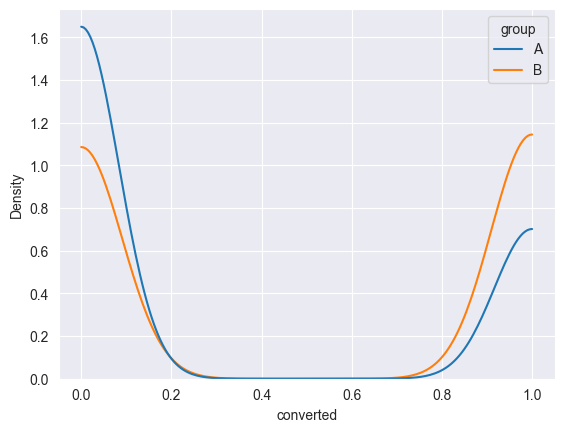

In [6]:
sns.kdeplot(df, x='converted', hue='group', cut=0)

In [10]:
def get_bootstrap(a, b, n=1000):
    a = np.random.choice(a, (n, len(a)), replace=True)
    b = np.random.choice(b, (n, len(b)), replace=True)
    return a.mean(axis=1), b.mean(axis=1)

In [11]:
a, b = get_bootstrap(df[df.group == 'A'].converted, df[df.group == 'B'].converted)
a.shape, b.shape

((1000,), (1000,))

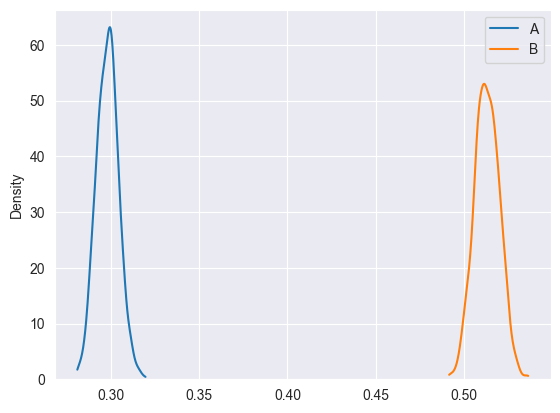

In [13]:
sns.kdeplot(a, cut=0, label='A')
sns.kdeplot(b, cut=0, label='B')
plt.legend()

In [14]:
df.cohort_age.describe()

count    10000.000000
mean        14.980300
std          8.376069
min          1.000000
25%          8.000000
50%         15.000000
75%         22.000000
max         29.000000
Name: cohort_age, dtype: float64

In [17]:
stats.ttest_ind(df[df.group == 'A'].converted, df[df.group == 'B'].converted)

TtestResult(statistic=np.float64(-22.39365244788215), pvalue=np.float64(2.0437553625034563e-108), df=np.float64(9998.0))

In [18]:
categories = ['age_group', 'channel', 'game_type', 'location']

In [19]:
df[categories].nunique()

age_group    4
channel      4
game_type    3
location     4
dtype: int64

In [25]:
df[categories + ['group']].value_counts().sort_index()

age_group  channel       game_type  location       group
18-24      Ads           Action     Asia           A        19
                                                   B        21
                                    Australia      A        21
                                                   B        36
                                    Europe         A        22
                                                            ..
45+        Social Media  Puzzle     Australia      B        26
                                    Europe         A        18
                                                   B        19
                                    North America  A        26
                                                   B        32
Name: count, Length: 384, dtype: int64